In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import data

In [19]:
data = pd.read_csv('../data/num_file/min_05/p040.csv')

In [20]:
print(data)

                  datetime  count
0      2022-04-21 01:40:00    200
1      2022-04-21 01:45:00      0
2      2022-04-21 01:50:00    241
3      2022-04-21 01:55:00    592
4      2022-04-21 02:00:00     27
...                    ...    ...
38995  2022-09-03 11:15:00   1042
38996  2022-09-03 11:20:00   1913
38997  2022-09-03 11:25:00   2024
38998  2022-09-03 11:30:00   2006
38999  2022-09-03 11:35:00   2170

[39000 rows x 2 columns]


If there is no people, use NaN.

In [21]:
data.loc[data['count']==0, 'count'] = np.NaN

In [22]:
print(data)

                  datetime   count
0      2022-04-21 01:40:00   200.0
1      2022-04-21 01:45:00     NaN
2      2022-04-21 01:50:00   241.0
3      2022-04-21 01:55:00   592.0
4      2022-04-21 02:00:00    27.0
...                    ...     ...
38995  2022-09-03 11:15:00  1042.0
38996  2022-09-03 11:20:00  1913.0
38997  2022-09-03 11:25:00  2024.0
38998  2022-09-03 11:30:00  2006.0
38999  2022-09-03 11:35:00  2170.0

[39000 rows x 2 columns]


<Axes: >

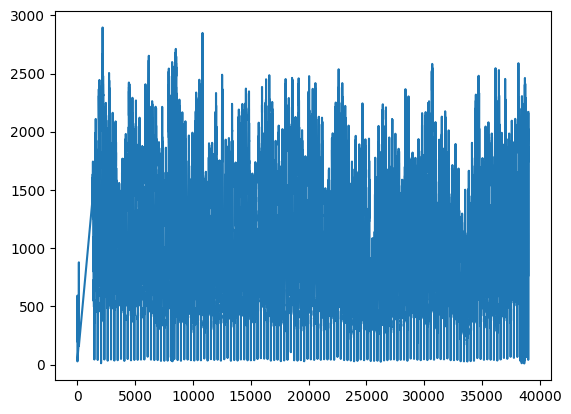

In [23]:
data['count'] = data['count'].interpolate(method='linear')
data['count'].plot()

## Normalize data

<Axes: >

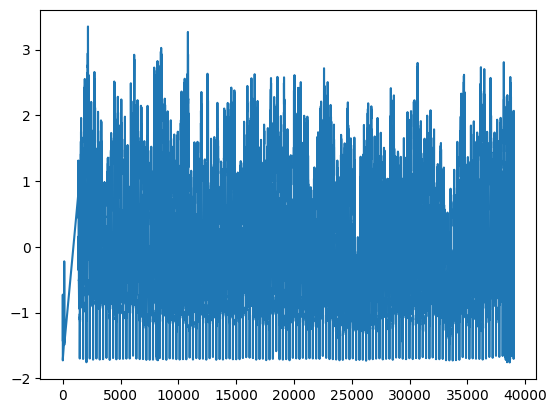

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data['count'] = scaler.fit_transform(data[['count']])
data['count'].plot()

In [25]:
print(data)

                  datetime     count
0      2022-04-21 01:40:00 -1.420353
1      2022-04-21 01:45:00 -1.384071
2      2022-04-21 01:50:00 -1.347789
3      2022-04-21 01:55:00 -0.726571
4      2022-04-21 02:00:00 -1.726537
...                    ...       ...
38995  2022-09-03 11:15:00  0.069861
38996  2022-09-03 11:20:00  1.611400
38997  2022-09-03 11:25:00  1.807854
38998  2022-09-03 11:30:00  1.775996
38999  2022-09-03 11:35:00  2.066252

[39000 rows x 2 columns]


In [26]:
encode_input_data = []
decode_input_data = []
decode_output_data = []
time_step = 12

for i in range(len(data)-time_step-1):
    encode_input_data.append(data['count'].values[i:i+time_step])
    decode_input_data.append(data['count'].values[i:i+time_step])
    decode_output_data.append(data['count'].values[i+1:i+time_step+1])

encode_input_data = np.array(encode_input_data)
decode_input_data = np.array(decode_input_data)
decode_output_data = np.array(decode_output_data)

In [27]:
encode_input_data = encode_input_data.reshape(encode_input_data.shape[0], encode_input_data.shape[1], 1)
decode_input_data = decode_input_data.reshape(decode_input_data.shape[0], decode_input_data.shape[1], 1)
decode_output_data = decode_output_data.reshape(decode_output_data.shape[0], decode_output_data.shape[1], 1)

In [28]:
train_size = int(len(encode_input_data)*0.8)
encode_input_data_train = encode_input_data[:train_size]
decode_input_data_train = decode_input_data[:train_size]
decode_output_data_train = decode_output_data[:train_size]
encode_input_data_test = encode_input_data[train_size:]
decode_input_data_test = decode_input_data[train_size:]
decode_output_data_test = decode_output_data[train_size:]

In [29]:
print(decode_output_data[:, -1, :])

[[-1.69051577]
 [-1.68815113]
 [-1.6857865 ]
 ...
 [ 1.6114003 ]
 [ 1.80785364]
 [ 1.77599634]]


## Model

In [30]:
from keras.layers import Input, LSTM, BatchNormalization, TimeDistributed, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [31]:
input_data = Input(shape=(time_step, 1))
x = LSTM(time_step, return_sequences=True)(input_data)
x = BatchNormalization()(x)
output_data = TimeDistributed(Dense(1))(x)

In [32]:
model = Model(input_data, output_data)

In [33]:
opt = Adam(learning_rate=0.01, clipnorm=1.0)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 12)            672       
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12)           48        
 hNormalization)                                                 
                                                                 
 time_distributed_1 (TimeDis  (None, 12, 1)            13        
 tributed)                                                       
                                                                 
Total params: 733
Trainable params: 709
Non-trainable params: 24
_________________________________________________________________


In [34]:
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
history = model.fit(encode_input_data_train, decode_output_data_train, epochs=100, batch_size=128, validation_split=0.1, callbacks=[es], shuffle=True)

Epoch 1/100
220/220 [==============================] - 2s 5ms/step - loss: 0.1661 - mae: 0.2188 - val_loss: 0.5928 - val_mae: 0.6872
Epoch 2/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0440 - mae: 0.1507 - val_loss: 0.1727 - val_mae: 0.3549
Epoch 3/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0443 - mae: 0.1528 - val_loss: 0.0572 - val_mae: 0.1695
Epoch 4/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0428 - mae: 0.1495 - val_loss: 0.0562 - val_mae: 0.1667
Epoch 5/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0440 - mae: 0.1505 - val_loss: 0.0363 - val_mae: 0.1400
Epoch 6/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0437 - mae: 0.1511 - val_loss: 0.0337 - val_mae: 0.1262
Epoch 7/100
220/220 [==============================] - 1s 4ms/step - loss: 0.0441 - mae: 0.1513 - val_loss: 0.0339 - val_mae: 0.1276
Epoch 8/100
220/220 [==============================] - 1s 4ms/step - 

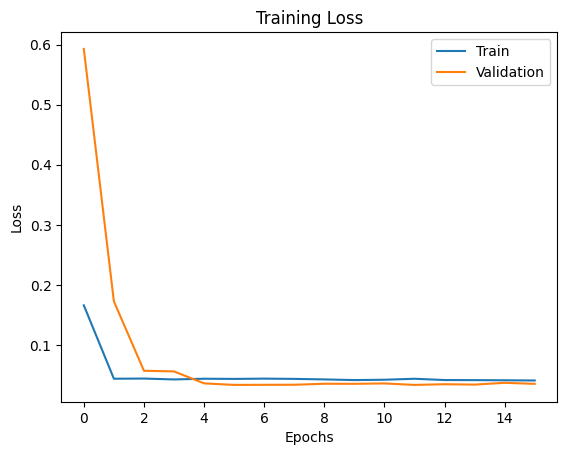

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [36]:
predict_test = model.predict(encode_input_data_test)

244/244 [==============================] - 0s 1ms/step


In [37]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])

In [38]:
print(predict_test_data)

[[ 747.5327]
 [ 823.6859]
 [ 767.5799]
 ...
 [1069.6158]
 [1594.5792]
 [1752.0281]]


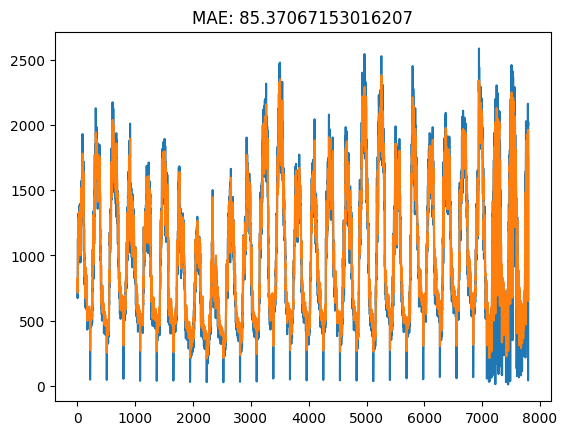

In [39]:
predict_test_data = scaler.inverse_transform(predict_test[:, -1, :])
decode_output_test_data = scaler.inverse_transform(decode_output_data_test[:, -1, :])
plt.plot(np.arange(decode_output_test_data.shape[0]), decode_output_test_data)
plt.plot(np.arange(predict_test_data.shape[0]), predict_test_data)
plt.title(f'MAE: {np.mean(np.abs((predict_test_data-decode_output_test_data)))}')
plt.show()

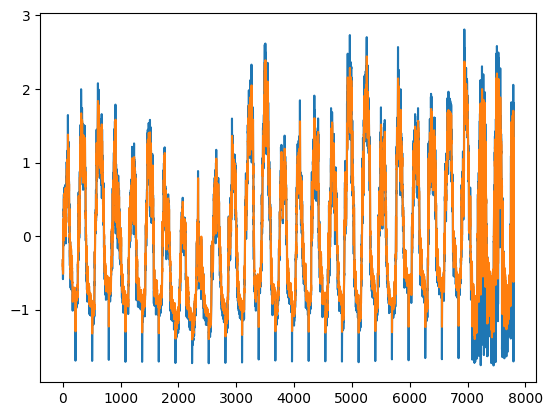

In [40]:
plt.plot(np.arange(decode_output_data_test.shape[0]), decode_output_data_test[:, -1, :])
plt.plot(np.arange(predict_test.shape[0]), predict_test[:, -1, :])
plt.show()

In [41]:
print(predict_test_data)

[[ 747.5327]
 [ 823.6859]
 [ 767.5799]
 ...
 [1069.6158]
 [1594.5792]
 [1752.0281]]


In [42]:
print(decode_output_test_data)

[[ 818.]
 [ 735.]
 [ 770.]
 ...
 [1913.]
 [2024.]
 [2006.]]


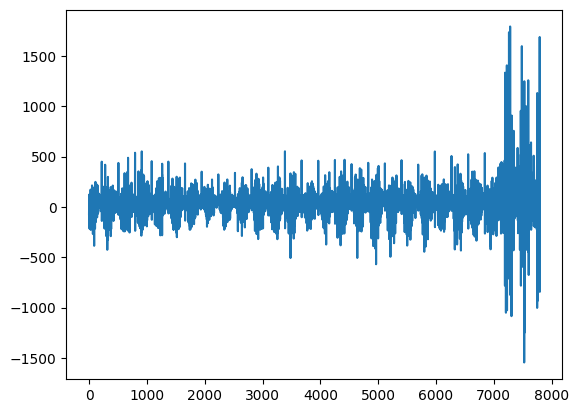

In [43]:
plt.plot(np.arange(decode_output_test_data.shape[0]), predict_test_data-decode_output_test_data)

In [44]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(decode_output_test_data, predict_test_data))

85.37067153016207
